In [1]:
import numpy as np
import struct

In [23]:
# functions
zfc_seq = lambda N, m : np.array([np.exp(-1j * np.pi * m * n * (n + 1) / N) for n in range(N)])
N_zfc = 257
zfc_seq_list = []
num_devs = 6
num_runs = 100
m_zfc_list = [7, 41, 71, 101, 131, 173, 193, 211, 239]

for i in range(num_devs):
    zfc_seq_list.append(zfc_seq(N_zfc, m_zfc_list[i]))

def parse_files(file_path):
    sample_size = 8
    with open(file_path, 'rb') as f:
        # Read the binary data
        binary_data = f.read()

    num_samples = len(binary_data) // sample_size
    samples = []
    for i in range(num_samples):
        # Extract real and imaginary parts from the binary data
        real_part, imag_part = struct.unpack('ff', binary_data[i * sample_size: (i + 1) * sample_size])
        # Create a complex number and append it to the list of samples
        samples.append(complex(real_part, imag_part))

    return np.array(samples)


def corr_find_peaks(filename, samples):
    peaks = np.zeros((num_devs,), dtype=int)
    for i in range(num_devs):
        corr_zfc = np.abs(np.correlate(samples, zfc_seq_list[i], mode='valid'))
        peak = np.argmax(corr_zfc).item()
        if corr_zfc[peak] < 5.0:
            print("File %s does not have a valid peak." %filename)
            peak = -1
        peaks[i] = peak

    return peaks


In [24]:
sync_ids = np.zeros((num_runs, num_devs), dtype=int)

for i in range(num_runs):
    file_path = "./storage/csd_F1_files_%d.dat" %(i+1)

    samples = parse_files(file_path)

    # correlated
    sync_ids[i, :] = corr_find_peaks(file_path, samples)

    

In [25]:
tmp, counts = np.unique(sync_ids, return_counts=True)
print(tmp)
print(counts)
max_min_diff = np.abs(sync_ids - np.max(sync_ids, axis=1, keepdims=True))
sync_counts = np.count_nonzero(np.max(max_min_diff, axis=1) < 10)
print(sync_counts)
sync_ind = np.argwhere(np.max(max_min_diff, axis=1) < 5).squeeze()
print(sync_ids[sync_ind, :])
del_ids = np.argwhere(np.sum(sync_ids, axis=1) < tmp[np.argmin(counts)].item()).squeeze()
np.delete(sync_ids, del_ids, axis=0)
print(np.mean(sync_ids - tmp[np.argmax(counts)].item()))
print(np.count_nonzero(np.sum(sync_ids == tmp[np.argmax(counts)].item(), axis=1) == num_devs))

[453 460 461 467 480 488 494 506 507 508 513 517 520 521 525 526 527 530
 533 535 538 539 540 543 545 546 549 553 555 556 558 561 562 563 564 567
 568 570 571 572 573 574 575 576 577 579 580 581 582 584 585 586 588 590
 600 602 606 609 612 613 614 620 647 650 660 669 673 705]
[  3   2   1   1   2   1   1   2   1   1   9   3   1   1   3   2   2   2
   1   1   1   2   1   1   2  12   1   2   4   1   8   2   3   7   1   1
   3   1   3   3 104 349  11   1   3   1   2   2   1   1   2   1   1   2
   2   1   1   3   3   1   2   1   1   1   1   1   1   1]
21
[[573 573 574 574 573 574]
 [574 573 574 575 574 574]
 [573 573 574 573 573 574]
 [574 573 574 574 574 574]
 [574 575 574 574 574 574]
 [574 573 574 575 571 574]
 [574 572 574 574 574 574]
 [573 573 575 574 575 574]
 [573 574 574 574 574 574]
 [574 573 574 574 574 574]
 [573 573 574 574 574 573]
 [574 574 574 575 573 574]
 [574 573 574 574 573 574]
 [573 573 574 574 573 574]
 [574 576 574 574 574 574]
 [574 573 574 574 574 574]]
-4.5166666

Text(0.5, 1.0, 'Sync-hist 100 runs 6 devs (avg-error 4.5e-6 sec)')

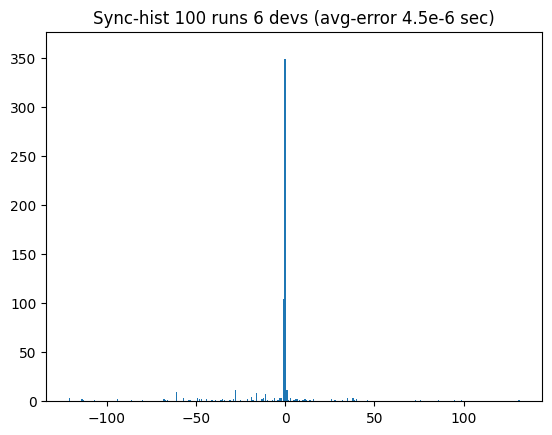

In [9]:
from matplotlib import pyplot as plt
plt.bar(tmp[:] - tmp[np.argmax(counts)].item(), counts[:])
plt.bar(0, np.max(counts) + 10, width=0.1, color="r")
plt.title("Sync-hist 100 runs 6 devs (avg-error 4.5e-6 sec)")